<a href="https://colab.research.google.com/github/Rajya-3154/tech-a-intern/blob/main/Olist_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brazilian-ecommerce:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F55151%2F2669146%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T135837Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00ec21bf805cfa9f151913639220c6db2be006b3f4fdee4b7cae6c53f60f2b41ed596fdd9a200b4cdec117106e13ef944b055e9f240dcc9d746bbb8e81fb58026dfcde7b047016029fc439b1c29b4920a524a6c3621584d6912a35850d10160f44da46576f7551c0d06193a24760847b663e35d4cd914d5722832015e70f6ae503f93fea2454e7dd21bfddce06379c672b6ac86e1e02465558597e46248b25c362d550a794bd1f5a4e0f37f01dec5c63f15c3d7d727dc967501b10fe3707a7834e0e43aa4a3c35e3ae0ad1776ae61efee0dca6b78872f4376d170dc5214fe8c7a5dda245460ca9b0068f1a1e670b28310ffe3c48f980b408812491bda359daa7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 44717580 bytes downloaded
Downloaded and uncompressed: brazilian-ecommerce
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv


In [3]:
# Loading up the needed datasets (Might add more later)

customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")

sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")


reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Assembling all datasets

df = pd.merge(customers, orders, on='customer_id')
df = pd.merge(df, order_items, on='order_id')
df = pd.merge(df, products, on='product_id')

df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,112.99,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,112.99,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,124.99,15.62,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,106.99,30.59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0


In [5]:
# Regrouping categories
category_mapping = {
  "moveis_escritorio": "Home and Living",
  "utilidades_domesticas": "nan",
  "casa_conforto": "Home and Living",
  "esporte_lazer": "Other",
  "informatica_acessorios": "Electronics and Entertainment",
  "nan": "Other",
  "brinquedos": "Kids and Babies",
  "moveis_decoracao": "Home and Living",
  "automotivo": "Other",
  "climatizacao": "Home and Living",
  "telefonia": "Electronics and Entertainment",
  "beleza_saude": "Fashion and Beauty",
  "ferramentas_jardim": "Other",
  "pet_shop": "Other",
  "cama_mesa_banho": "Home and Living",
  "bebes": "Kids and Babies",
  "relogios_presentes": "Fashion and Beauty",
  "moveis_cozinha_area_de_servico_jantar_e_jardim": "Home and Living",
  "perfumaria": "Fashion and Beauty",
  "artes": "Other",
  "papelaria": "Other",
  "fashion_roupa_feminina": "Fashion and Beauty",
  "consoles_games": "Electronics and Entertainment",
  "construcao_ferramentas_iluminacao": "Other",
  "alimentos_bebidas": "Other",
  "bebidas": "Other",
  "cool_stuff": "Other",
  "fashion_bolsas_e_acessorios": "Fashion and Beauty",
  "casa_construcao": "Other",
  "malas_acessorios": "Other",
  "eletronicos": "Electronics and Entertainment",
  "eletrodomesticos_2": "Home and Living",
  "fashion_roupa_masculina": "Fashion and Beauty",
  "eletroportateis": "Home and Living",
  "portateis_casa_forno_e_cafe": "Home and Living",
  "livros_interesse_geral": "Other",
  "eletrodomesticos": "Home and Living",
  "construcao_ferramentas_ferramentas": "Other",
  "sinalizacao_e_seguranca": "Other",
  "instrumentos_musicais": "Other",
  "construcao_ferramentas_construcao": "Other",
  "musica": "Electronics and Entertainment",
  "fashion_calcados": "Fashion and Beauty",
  "industria_comercio_e_negocios": "Other",
  "fashion_underwear_e_moda_praia": "Fashion and Beauty",
  "dvds_blu_ray": "Electronics and Entertainment",
  "construcao_ferramentas_seguranca": "Other",
  "alimentos": "Other",
  "telefonia_fixa": "Electronics and Entertainment",
  "moveis_sala": "Home and Living",
  "tablets_impressao_imagem": "Electronics and Entertainment",
  "market_place": "Other",
  "artigos_de_natal": "Other",
  "agro_industria_e_comercio": "Other",
  "construcao_ferramentas_jardim": "Other",
  "pcs": "Electronics and Entertainment",
  "moveis_quarto": "Home and Living",
  "audio": "Electronics and Entertainment",
  "livros_importados": "Other",
  "livros_tecnicos": "Other",
  "artigos_de_festas": "Other",
  "portateis_cozinha_e_preparadores_de_alimentos": "Home and Living",
  "pc_gamer": "Other",
  "moveis_colchao_e_estofado": "Home and Living",
  "la_cuisine": "Home and Living",
  "flores": "Other",
  "fraldas_higiene": "Kids and Babies",
  "cine_foto": "Electronics and Entertainment",
  "cds_dvds_musicais": "Electronics and Entertainment",
  "fashion_esporte": "Fashion and Beauty",
  "casa_conforto_2": "Home and Living",
  "artes_e_artesanato": "Other",
  "fashion_roupa_infanto_juvenil": "Fashion and Beauty",
  "seguros_e_servicos": "Other"
}


df['product_category_name'] = df['product_category_name'].replace(category_mapping)

print(df['product_category_name'].unique().tolist())

['Home and Living', 'nan', 'Other', 'Electronics and Entertainment', nan, 'Kids and Babies', 'Fashion and Beauty']


<Axes: xlabel='state'>

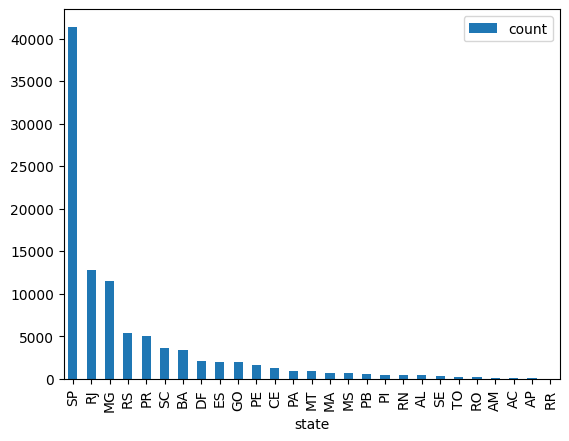

In [6]:
customer_location = df.groupby('customer_state')['customer_id'].nunique().reset_index()
customer_location.columns = ['state', 'count']
customer_location = customer_location.sort_values(by='count', ascending=False)

customer_location.plot(kind="bar", x="state", y="count")

Obviously, "SP" (Sao Polo) represents the biggest chunk of customers.  

It's worth mentioning that these states also have a lot of customers:
- MG (Minas Gerais)
- RJ (Rio de Janeiro)

Finally, smaller but still accounting for a consequent share of customers:
- RS (Rio Grande do Sul)
- PR (Paraná)
- SC (Santa Catarina)
- BA (Bahia)

> **Which, after further research, roughly corresponds to the population repartition by state.**

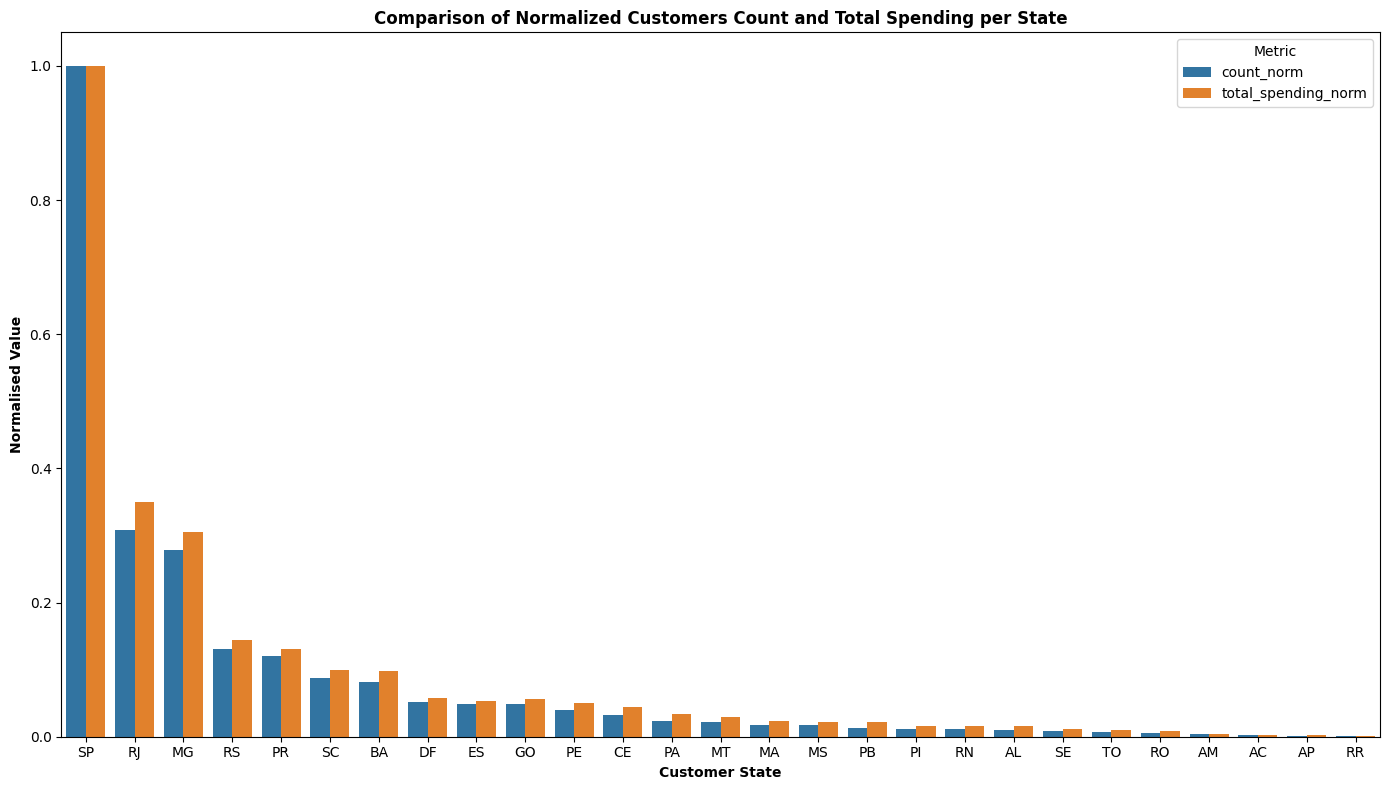

In [7]:
total_spending_per_state = df.groupby('customer_state')['price'].sum().reset_index()
total_spending_per_state.columns = ['state', 'total_spending']

merged_df = pd.merge(customer_location, total_spending_per_state, on='state')

merged_df['count_norm'] = merged_df['count'] / merged_df['count'].max()
merged_df['total_spending_norm'] = merged_df['total_spending'] / merged_df['total_spending'].max()

melted_df = pd.melt(merged_df, id_vars=['state'], value_vars=['count_norm', 'total_spending_norm'],
                    var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 8))
sns.barplot(data=melted_df, x='state', y='Value', hue='Metric')

plt.xlabel('Customer State', fontweight='bold')
plt.ylabel('Normalised Value', fontweight='bold')
plt.title('Comparison of Normalized Customers Count and Total Spending per State', fontweight='bold')

plt.tight_layout()
plt.show()

If it wasn't clear enough yet. Now we know for sure that there is a direct correlation between the number of customers in a state and the spending in the given state.

In [8]:
df['customer_id'].value_counts()

customer_id
fc3d1daec319d62d49bfb5e1f83123e9    21
bd5d39761aa56689a265d95d8d32b8be    20
be1b70680b9f9694d8c70f41fa3dc92b    20
adb32467ecc74b53576d9d13a5a55891    15
10de381f8a8d23fff822753305f71cae    15
                                    ..
d6aba909671bed4ffb393c2c4a9c1cb2     1
8da4932640e63aaa95a7c7090a618a96     1
76ba803a22ca2f0892036acaead6a065     1
85ba38b45737f1883ef0d242a0274b17     1
1ed0c832c2dd99570a59260e71768bdf     1
Name: count, Length: 98666, dtype: int64

In [9]:
# Analysing biggest customer

df[df['customer_id'] == 'fc3d1daec319d62d49bfb5e1f83123e9']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
95787,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95788,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95789,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95790,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95791,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95792,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95793,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95794,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95795,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0
95796,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,...,1.2,7.89,Fashion and Beauty,45.0,232.0,3.0,800.0,21.0,4.0,15.0


In [10]:
df.groupby('product_category_name')['customer_id'].nunique()

product_category_name
Electronics and Entertainment    15483
Fashion and Beauty               20012
Home and Living                  20202
Kids and Babies                   6779
Other                            29384
nan                               5884
Name: customer_id, dtype: int64

In [11]:
from sklearn.preprocessing import MinMaxScaler

def get_normalised_customer_spending_and_orders(df):

    outlier_price_threshold = 10000
    outlier_orders_threshold = 15

    spending_per_customer = df.groupby('customer_id')['price'].sum().reset_index()
    spending_per_customer.columns = ['customer_id', 'price']
    spending_per_customer = spending_per_customer[spending_per_customer['price'] < outlier_price_threshold]

    orders_count_per_customer = df['customer_id'].value_counts().reset_index()
    orders_count_per_customer.columns = ['customer_id', 'orders']
    orders_count_per_customer = orders_count_per_customer[orders_count_per_customer['orders'] < outlier_orders_threshold]

    customer_summary = pd.merge(spending_per_customer, orders_count_per_customer, on='customer_id')

    scaler = MinMaxScaler()

    customer_summary['normalized_price'] = scaler.fit_transform(customer_summary[['price']])
    customer_summary['normalized_orders'] = scaler.fit_transform(customer_summary[['orders']])

    return customer_summary

customer_spending_and_orders = get_normalised_customer_spending_and_orders(df)
customer_spending_and_orders

,customer_id,price,orders,normalized_price,normalized_orders
0,00012a2ce6f8dcda20d059ce98491703,89.80,1,0.012425,0.000000
1,000161a058600d5901f007fab4c27140,54.90,1,0.007550,0.000000
2,0001fd6190edaaf884bcaf3d49edf079,179.99,1,0.025023,0.000000
3,0002414f95344307404f0ace7a26f1d5,149.90,1,0.020820,0.000000
4,000379cdec625522490c315e70c7a9fb,93.00,1,0.012872,0.000000
...,...,...,...,...,...
98655,fffcb937e9dd47a13f05ecb8290f4d3e,78.00,1,0.010776,0.000000
98656,fffecc9f79fd8c764f843e9951b11341,54.90,1,0.007550,0.000000
98657,fffeda5b6d849fbd39689bb92087f431,47.90,1,0.006572,0.000000
98658,ffff42319e9b2d713724ae527742af25,199.90,1,0.027804,0.000000


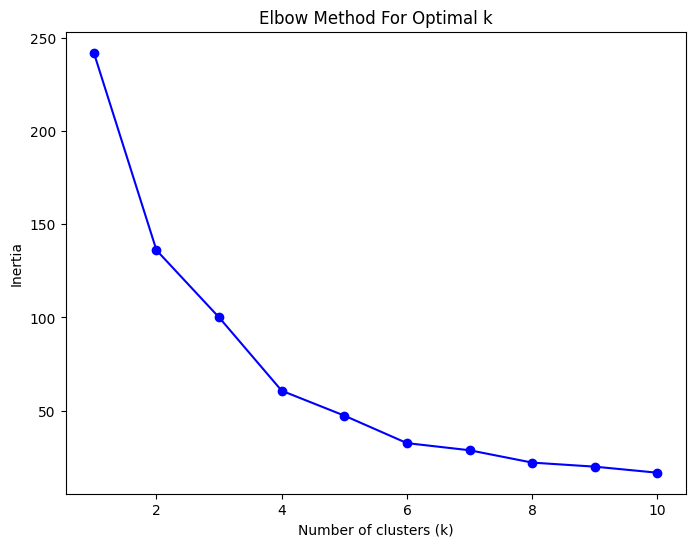

In [12]:
def plot_elbow_method(X, K):
    inertia = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

K = range(1, 11)
X = customer_spending_and_orders[['normalized_orders', 'normalized_price']]
plot_elbow_method(X, K)

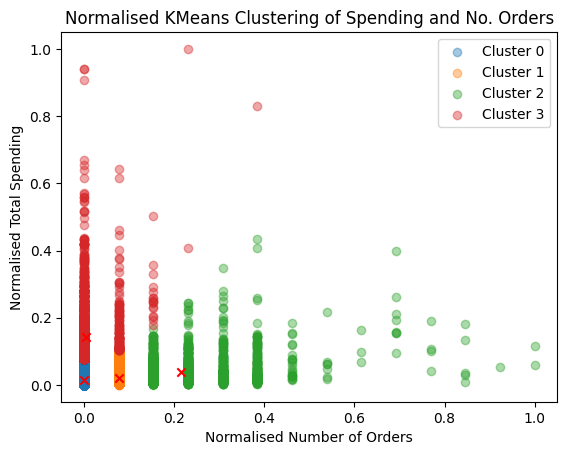

In [13]:
def cluster_and_plot(dataframe, clusters=4, title='K-Means Clustering'):

    kmeans = KMeans(n_clusters=clusters, random_state=21, n_init="auto")
    kmeans.fit(dataframe)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    customer_spending_and_orders['cluster_labels'] = kmeans.labels_
    unique_labels = np.unique(labels)

    for label in unique_labels:
        plt.scatter(dataframe.loc[labels == label, 'normalized_orders'], dataframe.loc[labels == label, 'normalized_price'], label=f'Cluster {label}', alpha=0.4)

    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
    plt.title(title)
    plt.xlabel('Normalised Number of Orders')
    plt.ylabel('Normalised Total Spending')
    plt.legend()
    plt.show()

cluster_and_plot(dataframe=X, title="Normalised KMeans Clustering of Spending and No. Orders")

### From this we can identify a few behaviours:
1. Minimum order, minimum spending:
    - Testing a product, or fullfilling an occasional need
2. Couple of orders, minium spending:
    - One-time need for a few "supplies" (in the general sense here)
3. A lot of orders, minimum to average spending:
    - One-time need as well, but on a bigger scale
4. Big spenders, minimum orders:
    - Unique need for an expensive product.

In [14]:
customer_spending_and_orders['orders'].describe()

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_date'] = df['order_purchase_timestamp'].dt.date
df['order_date'] = pd.to_datetime(df['order_date'])

df.sort_values(by=['customer_id', 'order_date'], inplace=True)
grouped = df.groupby('customer_id')

df['time_between_orders'] = grouped['order_date'].diff()

df['time_between_orders'].describe()

count              13984
mean     0 days 00:00:00
std      0 days 00:00:00
min      0 days 00:00:00
25%      0 days 00:00:00
50%      0 days 00:00:00
75%      0 days 00:00:00
max      0 days 00:00:00
Name: time_between_orders, dtype: object

### Calculating the time between orders doesn't make sense because apparently all of the customers purchased something only once.

In [15]:
df = df.merge(customer_spending_and_orders[['customer_id', 'cluster_labels']], on='customer_id', how='left')

df['cluster_labels'] = df['cluster_labels'].fillna(-1).astype(int)

In [16]:
pivot_table = df.pivot_table(index='customer_state', columns='cluster_labels', aggfunc='size', fill_value=0)

normalized_pivot_table = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
normalized_pivot_table.columns = [f'Cluster {i}' for i in normalized_pivot_table.columns]

normalized_pivot_table

,Cluster -1,Cluster 0,Cluster 1,Cluster 2,Cluster 3
customer_state,,,,,
AC,0.000000,0.083489,0.027104,0.139681,0.134998
AL,0.000000,0.415125,0.257487,0.197882,1.046237
AM,0.000000,0.151903,0.067760,0.209522,0.202497
AP,0.000000,0.062617,0.094864,0.093121,0.202497
BA,0.000000,3.397535,3.266025,2.910022,4.623692
CE,0.000000,1.348578,1.002846,1.175649,2.227472
DF,0.000000,2.161435,2.032796,2.048656,2.227472
ES,0.000000,2.095340,1.761756,1.583052,1.788728
GO,35.353535,2.024606,2.114108,1.967175,2.396220


- **Sao Paulo** (SP) is heavily represented **42~43% on the first 2 clusters**. Sao Paula represents **only 33% of the "Big Spender" cluster**.
- **Pará** (PA) barely represents **1% of the first 3 clusters**, but is more than **2% for the last clusters.**
- **Pernambuco** (PE) follows the same pattern, with **~1.5% on average** for the first 3 clusters, and **2.3% for the last one.**

In [17]:
target_states = ['AL', 'BA', 'CE', 'MT', 'MA', 'PA', 'PB', 'PE', 'PI', 'SP']

highlighted_table = normalized_pivot_table.loc[target_states]
highlighted_table

,Cluster -1,Cluster 0,Cluster 1,Cluster 2,Cluster 3
customer_state,,,,,
AL,0.000000,0.415125,0.257487,0.197882,1.046237
BA,0.000000,3.397535,3.266025,2.910022,4.623692
CE,0.000000,1.348578,1.002846,1.175649,2.227472
MT,0.000000,0.877793,1.002846,1.175649,1.653729
MA,0.000000,0.754879,0.623391,0.535444,1.181235
PA,0.000000,0.968239,0.650495,0.989408,2.159973
PB,0.000000,0.517167,0.460767,0.535444,1.417482
PE,0.000000,1.705725,1.084158,1.210569,2.396220
PI,0.000000,0.500933,0.284591,0.395763,1.147486


The biggest spenders seem to originate from the **Northeast Region of Brazil**.  


The market share dropping by 10% for Sao Paulo could indicate more local concurence or a difficult market.

In [18]:
df = pd.merge(df, reviews, on='order_id')

df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_width_cm,order_date,time_between_orders,cluster_labels,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,6273,osasco,SP,5f79b5b0931d63f1a42989eb65b9da6e,delivered,2017-11-14 16:08:26,2017-11-14 16:35:32,2017-11-17 15:32:08,...,22.0,2017-11-14,NaT,0,65645c124061b43b2edc38b05ee76aab,1,NaN,Tudo dentro do esperado,2017-11-29 00:00:00,2017-12-04 12:00:07
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,35550,itapecerica,MG,a44895d095d7e0702b6a162fa2dbeced,delivered,2017-07-16 09:40:32,2017-07-16 09:55:12,2017-07-19 19:09:37,...,11.0,2017-07-16,NaT,0,862cae301754fcafa8129022c8eca937,4,NaN,NaN,2017-07-26 00:00:00,2017-07-27 18:17:27
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,29830,nova venecia,ES,316a104623542e4d75189bb372bc5f8d,delivered,2017-02-28 11:06:43,2017-02-28 11:15:20,2017-03-01 15:24:20,...,35.0,2017-02-28,NaT,0,238e7cc8c4579a3d4db8f2a211db5b06,5,NaN,Muito bom,2017-03-07 00:00:00,2017-03-08 00:23:34
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,39664,mendonca,MG,5825ce2e88d5346438686b0bba99e5ee,delivered,2017-08-16 13:09:20,2017-08-17 03:10:27,2017-08-19 11:34:29,...,30.0,2017-08-16,NaT,0,c3a9be1f602ecba1c7bdff5639c975fe,5,NaN,NaN,2017-09-14 00:00:00,2017-09-15 00:26:09
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,4841,sao paulo,SP,0ab7fb08086d4af9141453c91878ed7a,delivered,2018-04-02 13:42:17,2018-04-04 03:10:19,2018-04-04 18:11:09,...,34.0,2018-04-02,NaT,0,fab6aa1b4c382a27ae8625faa342c229,4,NaN,NaN,2018-04-14 00:00:00,2018-04-16 20:17:51


In [19]:
review_pivot = df.pivot_table(index='review_score', columns='cluster_labels', aggfunc='size', fill_value=0)
normalized_review_table = review_pivot.div(review_pivot.sum(axis=0), axis=1) * 100
normalized_review_table.columns = [f'Cluster {i}' for i in normalized_pivot_table.columns]
normalized_review_table

,Cluster Cluster -1,Cluster Cluster 0,Cluster Cluster 1,Cluster Cluster 2,Cluster Cluster 3
review_score,,,,,
1,62.025316,9.704656,20.858812,27.093827,15.229983
2,0.000000,2.867496,5.408344,6.055992,3.134583
3,0.000000,8.201805,9.376274,9.359260,6.201022
4,0.000000,19.855290,15.858133,15.965796,17.785349
5,37.974684,59.370754,48.498437,41.525126,57.649063


In [20]:
category_pivot = df.pivot_table(index='product_category_name', columns='cluster_labels', aggfunc='size', fill_value=0)
normalized_category_table = category_pivot.div(category_pivot.sum(axis=0), axis=1) * 100
normalized_category_table.columns = [f'Cluster {i}' for i in normalized_pivot_table.columns]
normalized_category_table

,Cluster Cluster -1,Cluster Cluster 0,Cluster Cluster 1,Cluster Cluster 2,Cluster Cluster 3
product_category_name,,,,,
Electronics and Entertainment,35.443038,16.011739,14.078205,13.478209,18.629477
Fashion and Beauty,26.582278,21.037433,14.773510,10.390690,26.687328
Home and Living,18.987342,19.654896,31.185461,35.981475,14.221763
Kids and Babies,0.000000,7.209703,4.226903,2.921268,6.921488
Other,18.987342,30.138843,28.714030,27.502672,31.542700
nan,0.000000,5.947386,7.021892,9.725686,1.997245


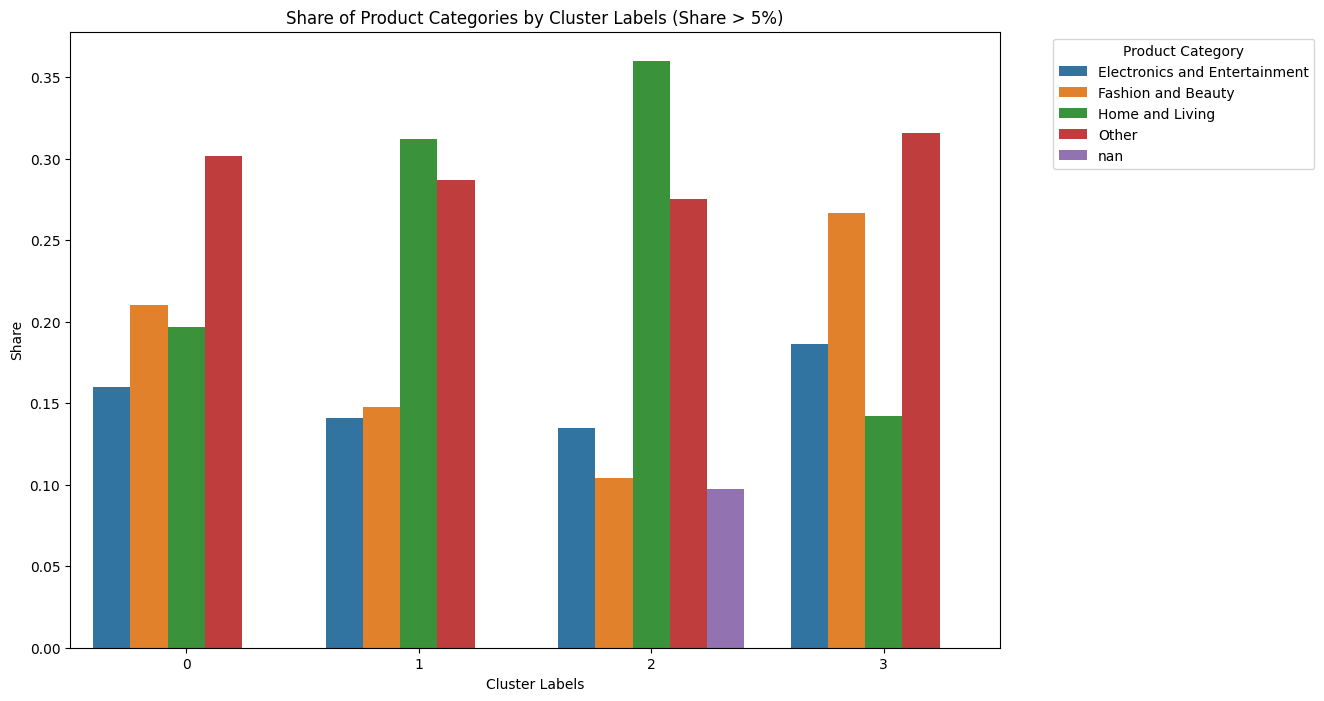

In [21]:
share_threshold = 0.08 # Percentage value (From 0 to 1)

filtered_df = df[df['cluster_labels'] != -1]

cluster_category_counts = filtered_df.groupby(['cluster_labels', 'product_category_name']).size().reset_index(name='count')

cluster_category_counts['share'] = cluster_category_counts.groupby('cluster_labels')['count'].transform(lambda x: x / x.sum())
cluster_category_counts_filtered = cluster_category_counts[cluster_category_counts['share'] > share_threshold]

plt.figure(figsize=(12, 8))
sns.barplot(x='cluster_labels', y='share', hue='product_category_name', data=cluster_category_counts_filtered)
plt.title('Share of Product Categories by Cluster Labels (Share > 5%)')
plt.xlabel('Cluster Labels')
plt.ylabel('Share')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

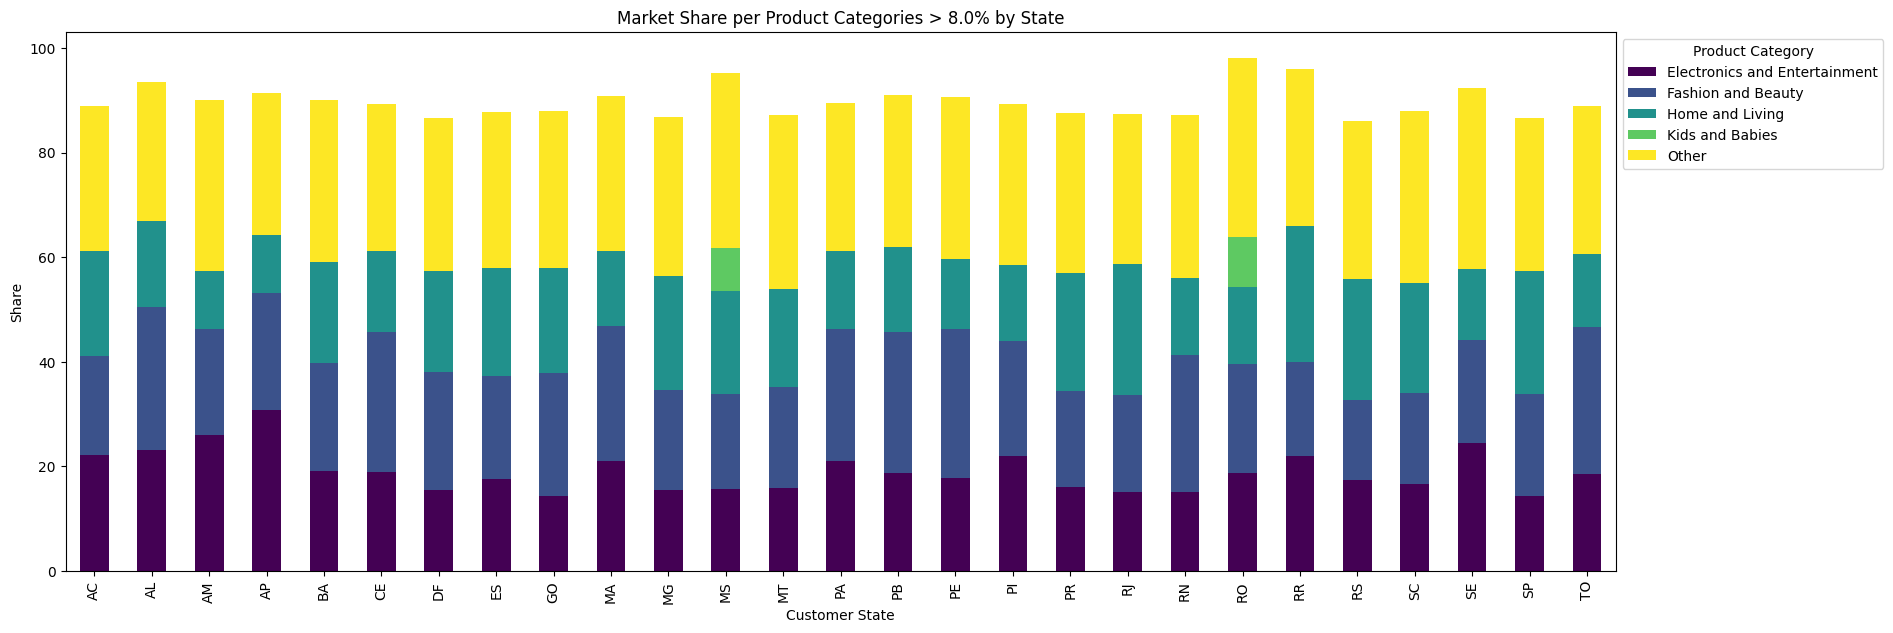

In [22]:
state_category_counts = df.groupby(['customer_state', 'product_category_name']).size().reset_index(name='count')
state_category_counts['share'] = state_category_counts.groupby('customer_state')['count'].transform(lambda x: x / x.sum())
state_category_counts_filtered = state_category_counts[state_category_counts['share'] > share_threshold]

state_category_pivot = state_category_counts_filtered.pivot(index='customer_state', columns='product_category_name', values='share').fillna(0) * 100

fig, ax = plt.subplots(figsize=(20, 7))
state_category_pivot.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

plt.title(f'Market Share per Product Categories > {share_threshold * 100}% by State')
plt.xlabel('Customer State')
plt.ylabel('Share')
plt.legend(title='Product Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

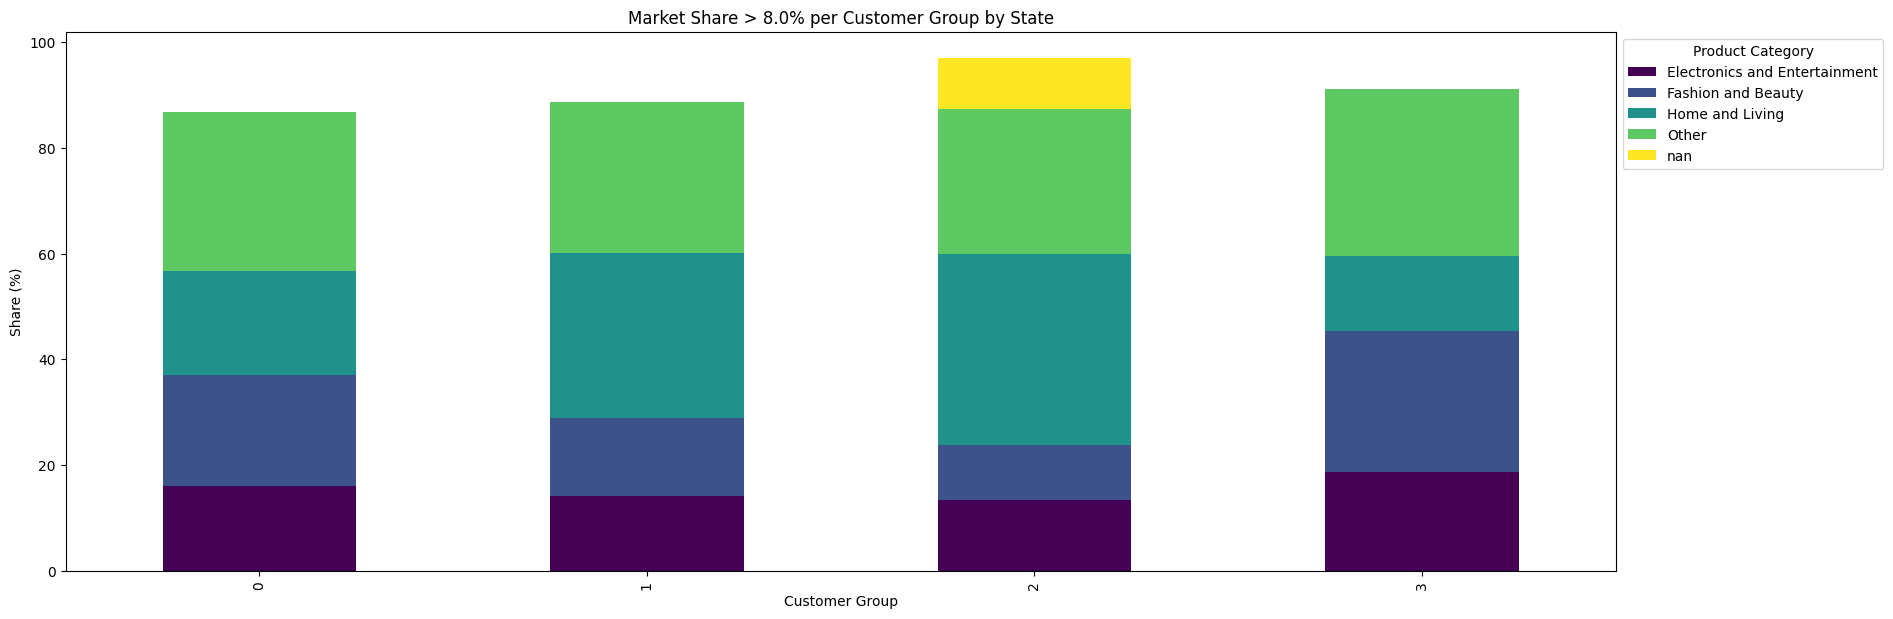

In [23]:
filtered_df = df[df['cluster_labels'] != -1]

cluster_category_counts = filtered_df.groupby(['cluster_labels', 'product_category_name']).size().reset_index(name='count')

cluster_category_counts['share'] = cluster_category_counts.groupby('cluster_labels')['count'].transform(lambda x: x / x.sum())
cluster_category_counts_filtered = cluster_category_counts[cluster_category_counts['share'] > share_threshold]

state_category_pivot = cluster_category_counts_filtered.pivot(index='cluster_labels', columns='product_category_name', values='share').fillna(0) * 100

fig, ax = plt.subplots(figsize=(20, 7))
state_category_pivot.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

plt.title(f'Market Share > {share_threshold * 100}% per Customer Group by State')
plt.xlabel('Customer Group')
plt.ylabel('Share (%)')
plt.legend(title='Product Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()